# Ερώτημα 1

Merge the common id from all months and enter the columns on_febrouary, on_march, on_april where they have values 0 or 1 in their rows depending on if the property existed in any of those months. The columns price_febrouary, price_march, price_april are also created, which have the prices for each month of the property.
At the same time, the NaNs are cleared from columns of great importance for the following questions. 

## Pre-process train.csv

In [130]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce


data_path = "/home/andreas/6o_e3amhno/data_mining/ergasia1/data"

# find the months of data and sort them
months = [month for month in os.listdir(data_path)]
all_months = ["january", "febrouary", "march", "april", "may", "june", "july", "august", "september", "october", "november", "december"]
months.sort(key=lambda x: all_months.index(x))


# set the columns and the data types
train_data_types = {"id": int, "zipcode": object, "transit": object, "bedrooms": object,
                    "beds": object, "review_scores_rating": object, "number_of_reviews": int,
                    "neighbourhood": object, "name": object, "latitude": float, "longitude": float,
                    "last_review": object, "instant_bookable": object, "host_since": object,
                    "host_response_rate": object, "host_identity_verified": object,
                    "host_has_profile_pic": object, "first_review": object, "description": object,
                    "city": object, "cancellation_policy": object, "bed_type": object,
                    "bathrooms": float, "accommodates": int, "amenities": object, "room_type": object,
                    "property_type": object, "price": object, "availability_365": int, "minimum_nights": int}

train_data_columns = list(train_data_types.keys())
train_data_columns_variable = ["price", "number_of_reviews", "last_review"]
train_data_columns_not_variable = list(set(train_data_columns) - set(train_data_columns_variable) - set(["id"]))

# open every listings file from each month
csv_files = []
for month in months:
    print(data_path+"/"+month+"/listings.csv")
    csv_file_path = data_path+"/"+month+"/listings.csv"
    csv_file = pd.read_csv(csv_file_path, usecols=train_data_columns, dtype=train_data_types)
    csv_file.rename(columns={train_data_column : train_data_column+"_"+month for train_data_column in train_data_columns[1:]}, inplace=True)
    csv_file = pd.concat([csv_file, pd.DataFrame(columns=["on_"+month])])
    csv_file.loc[:,"on_"+month] = 1
    csv_files.append(csv_file)


# merge all the csv files
csv_train = reduce(lambda left,right : pd.merge(left, right, on="id",  how="outer"), csv_files)


# delete duplicate columns and keep the data that matters and drop data
csv_train = pd.concat([csv_train, pd.DataFrame(columns=train_data_columns_not_variable)])

for train_data_column in train_data_columns_not_variable:
    columns = [train_data_column+"_"+month for month in months]
    columns.append(train_data_column)
    csv_train.loc[:, columns] = csv_train.loc[:, columns].ffill(axis=1)
    for month in months:
        del csv_train[train_data_column+"_"+month]

# transform price from str to float
for month in months:
    csv_train["price_"+month] = csv_train["price_"+month].astype(str).apply(lambda x: float(x.replace("$","").replace(",","")) )
csv_train["average_price"] = csv_train[["price_"+month for month in months]].mean(axis=1)

# merging reviews to last review
columns = ["last_review_"+month for month in months]
csv_train["last_review"] = csv_train[columns].astype(str).max(axis=1)
csv_train["number_of_reviews"] = csv_train["number_of_reviews_"+months[-1]]
for month in months:
    del csv_train["last_review_"+month]
    del csv_train["number_of_reviews_"+month]

# droping rows that are missing essential data
csv_train = csv_train[csv_train.name.notna() & csv_train.description.notna() & csv_train.accommodates.notna() & csv_train.longitude.notna() & csv_train.latitude.notna() & csv_train.room_type.notna() & csv_train.city.notna()].reset_index(drop=True)

# saving train_csv
# csv_train.to_csv("csv_train.csv")

# plt style
plt.style.use('seaborn')
color_palet = plt.cm.BuPu
def colors(variables):
    return color_palet(np.linspace(0, 1, variables))

# print head
train = csv_train
csv_train.head(3)

/home/andreas/6o_e3amhno/data_mining/ergasia1/data/febrouary/listings.csv
/home/andreas/6o_e3amhno/data_mining/ergasia1/data/march/listings.csv
/home/andreas/6o_e3amhno/data_mining/ergasia1/data/april/listings.csv


,id,price_febrouary,on_febrouary,price_march,on_march,price_april,on_april,instant_bookable,accommodates,latitude,...,description,host_identity_verified,first_review,city,host_has_profile_pic,host_response_rate,minimum_nights,average_price,last_review,number_of_reviews
0,10595.0,71.0,1.0,72.0,1.0,73.0,1.0,t,8.0,37.98888,...,Athens Furnished Apartment No6 is 3-bedroom ap...,t,2011-05-20,Athens,t,100%,1.0,72.0,2019-04-08,19.0
1,10988.0,82.0,1.0,82.0,1.0,82.0,1.0,t,5.0,37.98843,...,Athens Furnished Apartment No4 is 2-bedroom ap...,t,2012-10-21,Athens,t,100%,1.0,82.0,2017-11-23,31.0
2,10990.0,47.0,1.0,48.0,1.0,49.0,1.0,t,4.0,37.98783,...,Athens Furnished Apartment No3 is 1-bedroom ap...,t,2012-09-06,Athens,t,100%,1.0,48.0,2019-03-03,29.0


## Question 1.1

Calculate the sum of the same values in the room_type field 

Text(0, 0.5, '# of airbnbs')

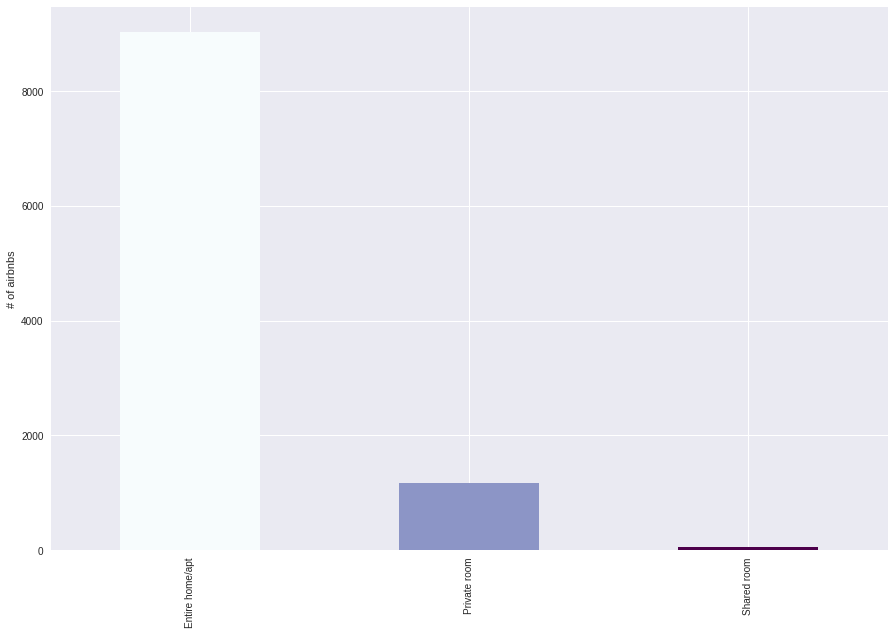

In [131]:
# 1.1
room_types = train["room_type"].value_counts()

# plotting
colors = color_palet(np.linspace(0, 1, len(room_types)))
room_types.plot(kind='bar', stacked=True, figsize=(15, 10), color=colors)
plt.ylabel("# of airbnbs")

## Question 1.2

The price_febrouary, price_march, price_april columns are used and their average value is shown. 

Text(0, 0.5, 'average price')

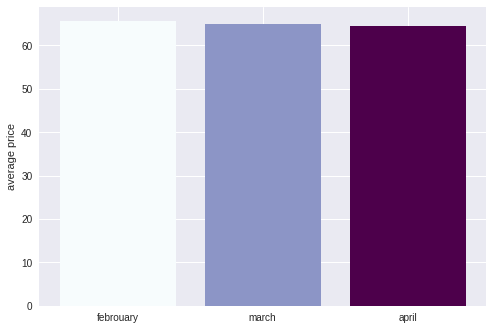

In [132]:
# 1.2
average_prices = [train["price_"+month].mean() for month in months]

# plotting
colors = color_palet(np.linspace(0, 1, len(months)))
plt.bar(months, average_prices, color=colors)
plt.ylabel("average price")

## Question 1.3

Group by neighborhoods and sum in the number of reviews 

,number_of_reviews
neighbourhood,
Plaka,46626.0
Koukaki,30228.0
Neos Kosmos,27571.0
Psyri,17752.0
Metaxourgeio,15307.0


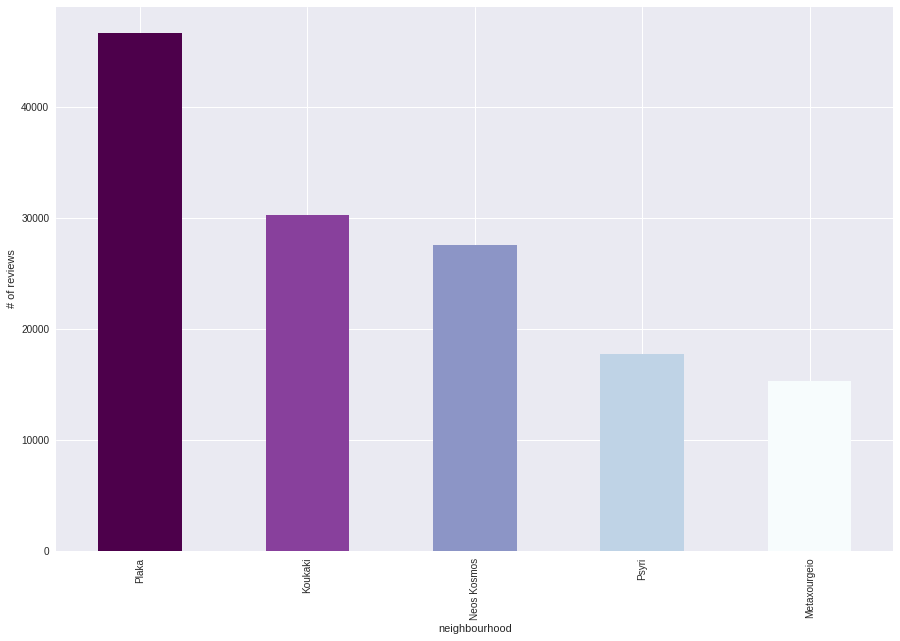

In [133]:
# 1.3
neighbourhood_group = train[["number_of_reviews", "neighbourhood"]].groupby("neighbourhood").sum()
neighbourhood_group = neighbourhood_group.sort_values(by="number_of_reviews", ascending=False).head(5)


# plotting
colors = color_palet(np.linspace(1, 0, 5))
neighbourhood_group.number_of_reviews.plot(kind='bar', figsize=(15, 10), color=colors)
plt.ylabel("# of reviews")

neighbourhood_group.sort_values(by="number_of_reviews", ascending=False).head(5)

## Question 1.4

This question is grouped by the neighborhoods and the columns on_febrouary, on_march, on_april are added for each month

Finally, the graphs show the area with the most properties for each month 

,on_febrouary,on_march,on_april
neighbourhood,,,
Kolonaki,563.0,579.0,598.0
Pangrati,575.0,578.0,596.0
Koukaki,746.0,767.0,803.0
Neos Kosmos,760.0,787.0,804.0
Plaka,1020.0,1023.0,1105.0


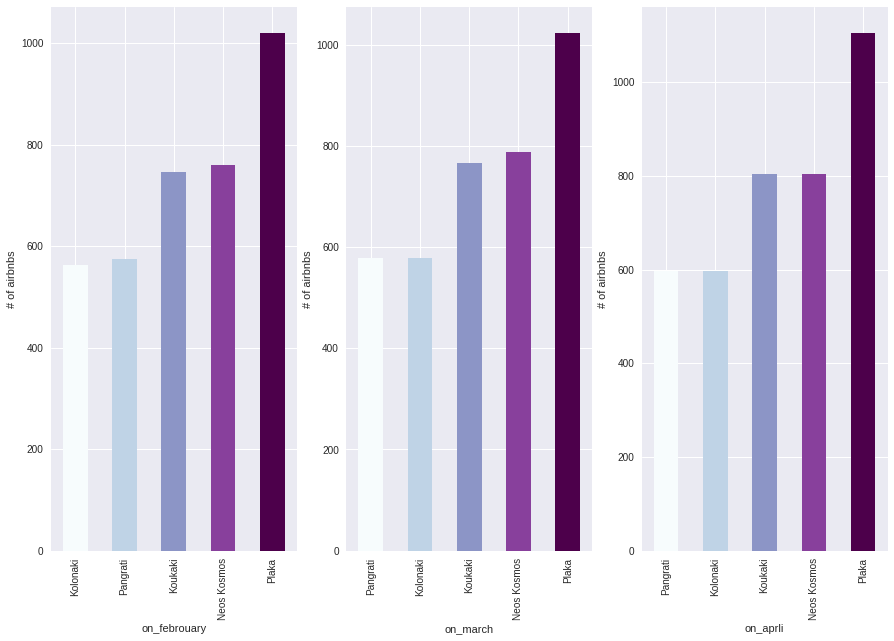

In [134]:
# 1.4
columns = ["on_"+month for month in months]
columns.append("neighbourhood")
neighbourhood_group = train[columns].groupby("neighbourhood").sum()

# plotting
fig, axes = plt.subplots(nrows=1, ncols=3)
colors = color_palet(np.linspace(0, 1, 5))

neighbourhood_group.on_febrouary.sort_values().tail(5).plot(ax=axes[0], kind='bar', figsize=(15, 10), color=colors)
axes[0].set_ylabel("# of airbnbs")
axes[0].set_xlabel("on_febrouary")

neighbourhood_group.on_march.sort_values().tail(5).plot(ax=axes[1], kind='bar', figsize=(15, 10), color=colors)
axes[1].set_ylabel("# of airbnbs")
axes[1].set_xlabel("on_march")

neighbourhood_group.on_april.sort_values().tail(5).plot(ax=axes[2], kind='bar', figsize=(15, 10), color=colors)
axes[2].set_ylabel("# of airbnbs")
axes[2].set_xlabel("on_aprli")

neighbourhood_group.sort_values(by=columns[0]).tail(5)

## Question 1.5

This question is grouped by the neighborhoods and the columns on_febrouary, on_march, on_april are added for each month

The graphs show the total for each ghetto the area with the most properties with the sum of all months 

Text(0, 0.5, '# of airbnbs')

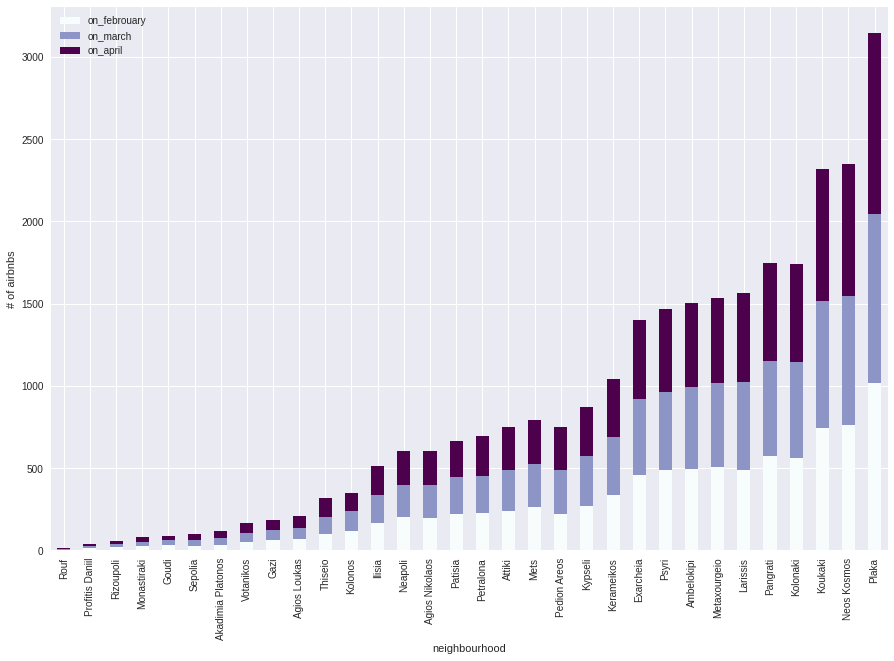

In [135]:
# 1.5
columns = ["on_"+month for month in months]
columns.append("neighbourhood")
neighbourhood_group = train[columns].groupby("neighbourhood").sum().sort_values(columns[1])

# ploting
colors = color_palet(np.linspace(0, 1, len(neighbourhood_group.columns)))
neighbourhood_group.plot(kind='bar', stacked=True, figsize=(15, 10), color=colors)
plt.ylabel("# of airbnbs")

## Question 1.6

This question adds up the different properties per neighborhood

The graphs show the histogram of the neighborhood variable 

Text(0.5, 0, '# of airbnbs')

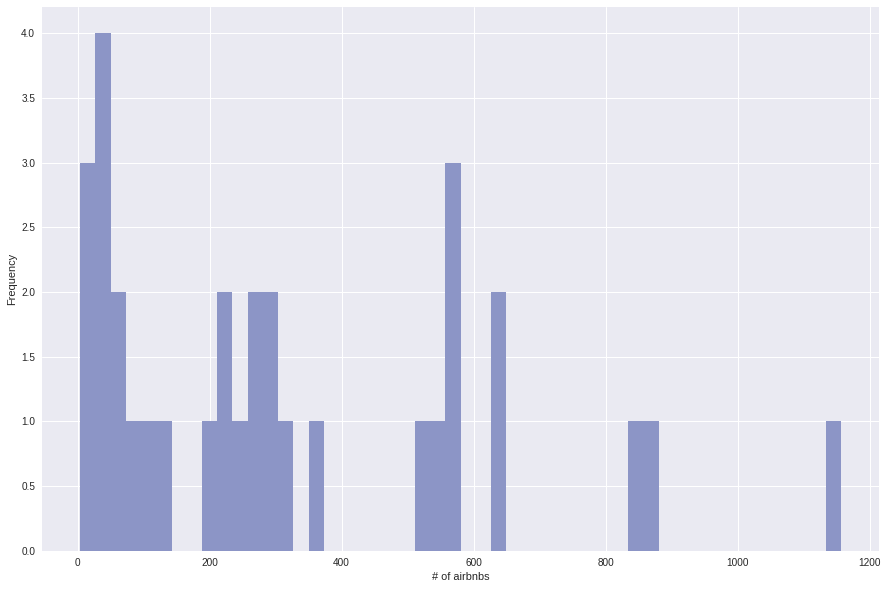

In [136]:
# 1.6
neighbourhood_group = train["neighbourhood"].value_counts(ascending=True)

# ploting
colors = color_palet(np.linspace(0.5, 1, 1))
neighbourhood_group.plot(kind='hist', stacked=True, figsize=(15, 10), color=colors, bins=50)
plt.xlabel("# of airbnbs")

## Question 1.7

This question is grouped in the neighborhoods and by neighborhood is the most common room type

The graph shows the types of rooms per neighborhood 

,0
neighbourhood,
Agios Loukas,Entire home/apt
Agios Nikolaos,Entire home/apt
Akadimia Platonos,Entire home/apt
Ambelokipi,Entire home/apt
Attiki,Entire home/apt
Exarcheia,Entire home/apt
Gazi,Entire home/apt
Goudi,Entire home/apt
Ilisia,Entire home/apt


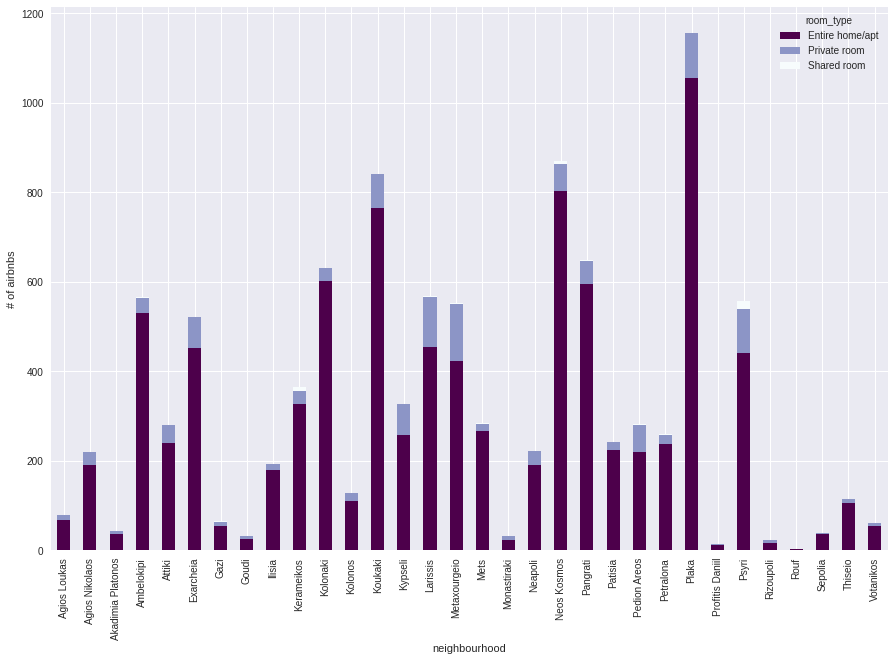

In [137]:
# 1.7
neighbourhood_group = train[["room_type", "neighbourhood"]].groupby("neighbourhood")

# plotting
colors = color_palet(np.linspace(1, 0, 3))
neighbourhood_group.room_type.value_counts(ascending=True).unstack().plot(kind='bar', stacked=True, figsize=(15, 10), color=colors)
plt.ylabel("# of airbnbs")

neighbourhood_group.room_type.value_counts().unstack().idxmax(axis=1).to_frame()

## Question 1.8

This question is grouped by neighborhoods and per room type and is the average price per type

The graph shows the prices of all rooms 

,average_price
room_type,
Private room,75.595055


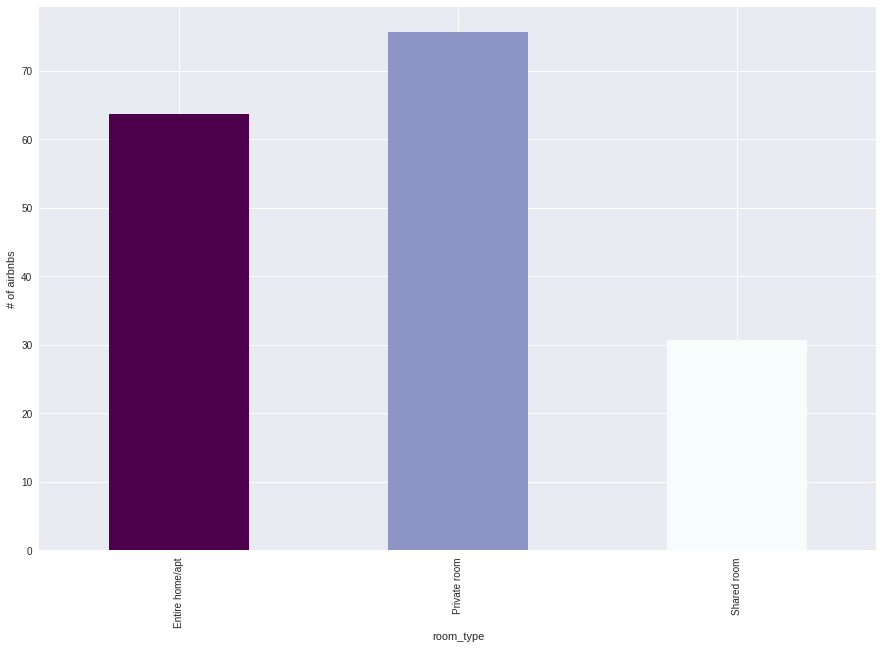

In [138]:
# 1.8
neighbourhood_group = train[["average_price", "room_type"]].groupby("room_type").mean()

# plotting
colors = color_palet(np.linspace(1, 0, 3))
neighbourhood_group.average_price.plot(kind='bar', stacked=True, figsize=(15, 10), color=colors)
plt.ylabel("# of airbnbs")

neighbourhood_group.loc[neighbourhood_group.idxmax()]

## Question 1.9

In this query we tried to show on the map all 10000 airbnb but the computer never showed them (not even in google colab) so we only show 1000 airbnb indicators and below a heat map with all the coordinates registered.

In [139]:
# 1.9
import folium
from folium import plugins
from branca.element import Figure

fig = Figure(width=950, height=600)
map = folium.Map(location=[37.991811, 23.733400],zoom_start=13, width=950, height=600, control_scale=True)
fig.add_child(map)

for index,row in train.iterrows():
    folium.Marker(location=[row.loc["latitude"], row.loc["longitude"]], 
                  popup=row.loc["room_type"]+" "+str(row.loc["accommodates"])+" "+str(int(row.loc["average_price"]))+" $",
                  tooltip=row.loc["name"],
                  icon=folium.Icon(icon="home", prefix="fa")).add_to(map)

    # folium.Marker(location=[row.loc["latitude"], row.loc["longitude"]]).add_to(map)
    if(index>1000):
      break;
map

In addition there is a heatmap

In [140]:

matrix_coordinates = train[['latitude', 'longitude']].values
heat_fig = Figure(width=950, height=600)
heat_map = folium.Map(location=[37.991811, 23.733400],zoom_start=13, width=950, height=600, control_scale=True)
heat_fig.add_child(heat_map)

heat_map.add_children(plugins.HeatMap(matrix_coordinates, radius=14))
heat_map

/home/andreas/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.
  


## Question 1.10

Wordcloud of the neighbourhoods

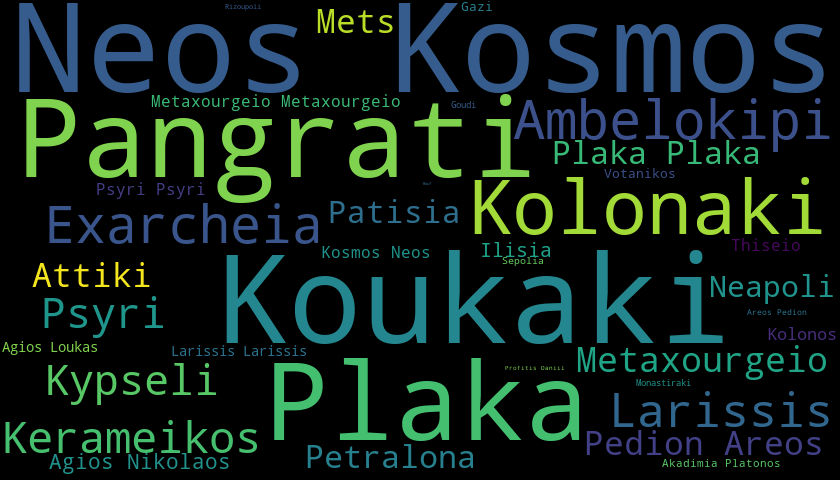

In [141]:
# 1.10
from wordcloud import WordCloud, STOPWORDS
wcloud = WordCloud(stopwords= set(STOPWORDS), width=840, height=480)

neighbourhood_words = train["neighbourhood"].str.cat(sep=" ")
wcloud.generate(neighbourhood_words)
wcloud.to_image()

Wordcloud of transit

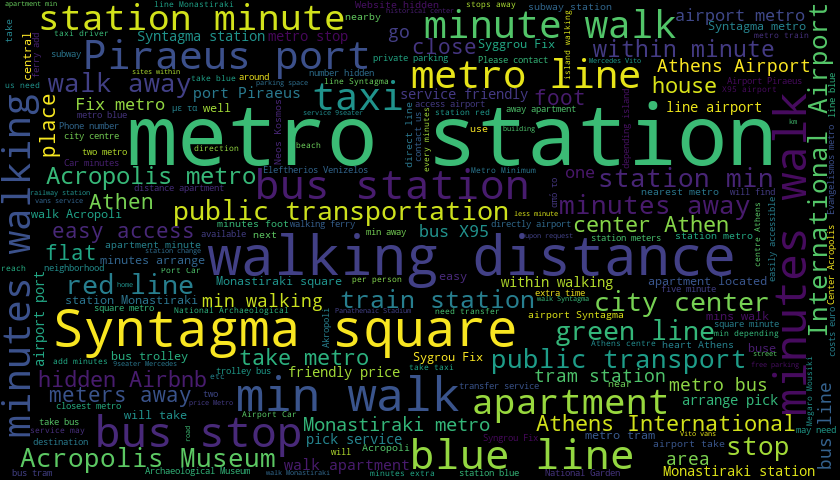

In [142]:
transit_words = train["transit"].str.cat(sep=" ")
wcloud.generate(transit_words)
wcloud.to_image()

Wordcloud of descriptions

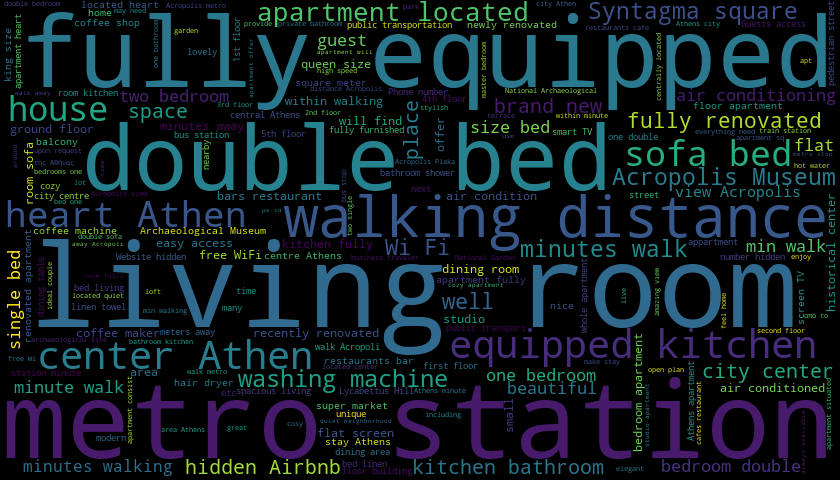

In [143]:
description_words = train["description"].str.cat(sep=" ")
wcloud.generate(description_words)
wcloud.to_image()

Wordcloud of last reviews

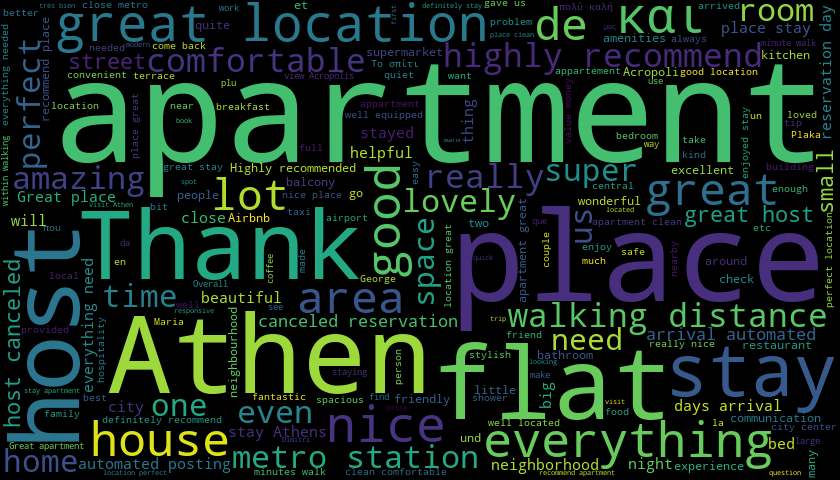

In [144]:
# exctract reviews from review file all last reviews must be at the file of the last month
reviews_path = data_path+"/"+months[-1]+"/reviews.csv"
reviews = pd.read_csv(reviews_path)

# merge reviews with last dates
reviews = pd.merge(train[["id", "last_review"]], reviews, left_on=["id", "last_review"], right_on=["listing_id", "date"])

reviews_words = reviews["comments"].str.cat(sep=" ")
wcloud.generate(reviews_words)
wcloud.to_image()

## Question 1.11 the average price per neighborhood 

Find the average price for each property and then the average price for each neighborhood and display them 

Text(0, 0.5, 'Relative price')

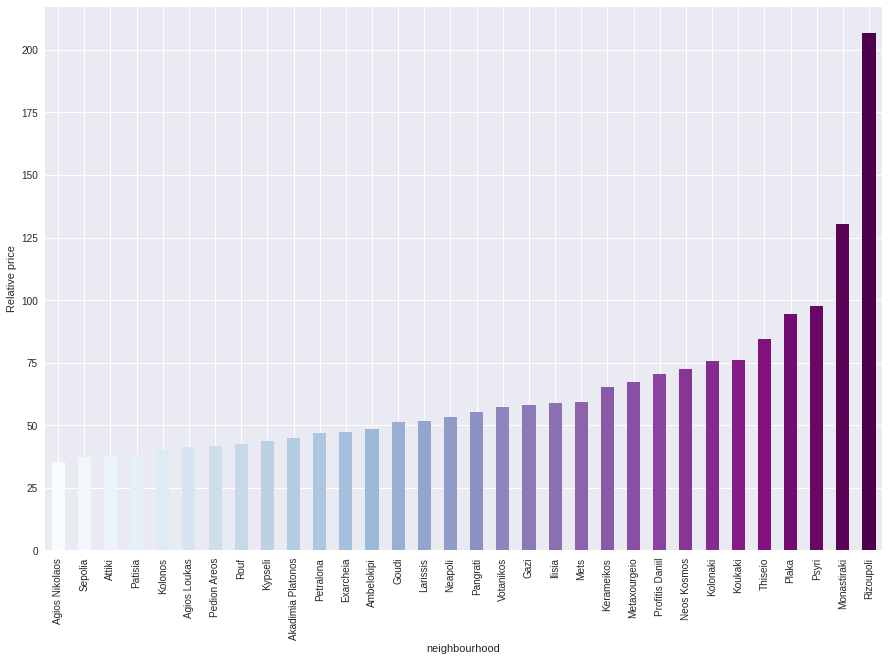

In [145]:
# 1.12 find the average price foe each neighbourhood

neighbourhood_group = train[["average_price", "neighbourhood"]].groupby("neighbourhood").mean()

# ploting
colors = color_palet(np.linspace(0, 1, len(neighbourhood_group)))
neighbourhood_group.average_price.sort_values().plot(kind='bar', stacked=True, figsize=(15, 10), color=colors)
plt.ylabel("Relative price")

The result that Rizoupoli is the most expensive area seems a bit strange ...

If we take the rooms located in Rizoupoli, we will sort them and find the one with the highest price,
we will see a 32 square meter apartment that opened only in March and was priced at 4030 euros !? 

In [146]:
rizoupolh = train[train.neighbourhood == "Rizoupoli"].sort_values(by="average_price").tail(1)
rizoupolh

,id,price_febrouary,on_febrouary,price_march,on_march,price_april,on_april,instant_bookable,accommodates,latitude,...,description,host_identity_verified,first_review,city,host_has_profile_pic,host_response_rate,minimum_nights,average_price,last_review,number_of_reviews
9378,32624782.0,NaN,NaN,4030.0,1.0,NaN,NaN,t,4.0,38.02924,...,Καινούργιο διαμέρισμα 32τμ. Σαλόνι με κουζίνα ...,f,NaN,Athina,t,NaN,1.0,4030.0,nan,NaN


Obviously this will be a mistake as no one would want to charge 4030 for 32 square meters.
Therefore if we delete this entry we will be able to have more correct results.
In addition, in many apartments there are errors in prices and many for example instead of 70 write 7 thousand euros. For this reason it would be good to cut the prices over 1000 euros as it does not make sense for any airbnb house in Athens to have such a price. 

Text(0, 0.5, 'Relative price')

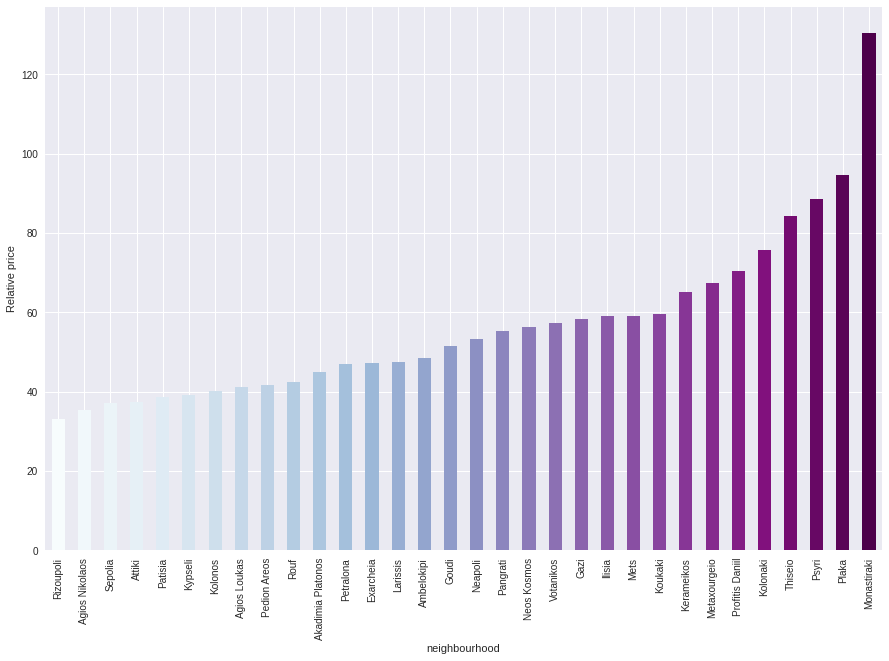

In [147]:
train = train.drop(train[train.average_price > 1000].index)
neighbourhood_group = train[["average_price", "neighbourhood"]].groupby("neighbourhood").mean()

# ploting
colors = color_palet(np.linspace(0, 1, len(neighbourhood_group)))
neighbourhood_group.average_price.sort_values().plot(kind='bar', stacked=True, figsize=(15, 10), color=colors)
plt.ylabel("Relative price")

## Question 1.12 Find the number of airbnb that exist and their price as a function of their distance from the Acropolis 

In the next question we will calculate the number of airbnb that exist as a function of distance from a point. In this case we will use the distance from the citadel.

The actual distance between two coordinates in a sphere is calculated using the Haversinus formula 

![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/a65dbbde43ff45bacd2505fcf32b44fc7dcd8cc0)

Text(0, 0.5, '# of airbnbs')

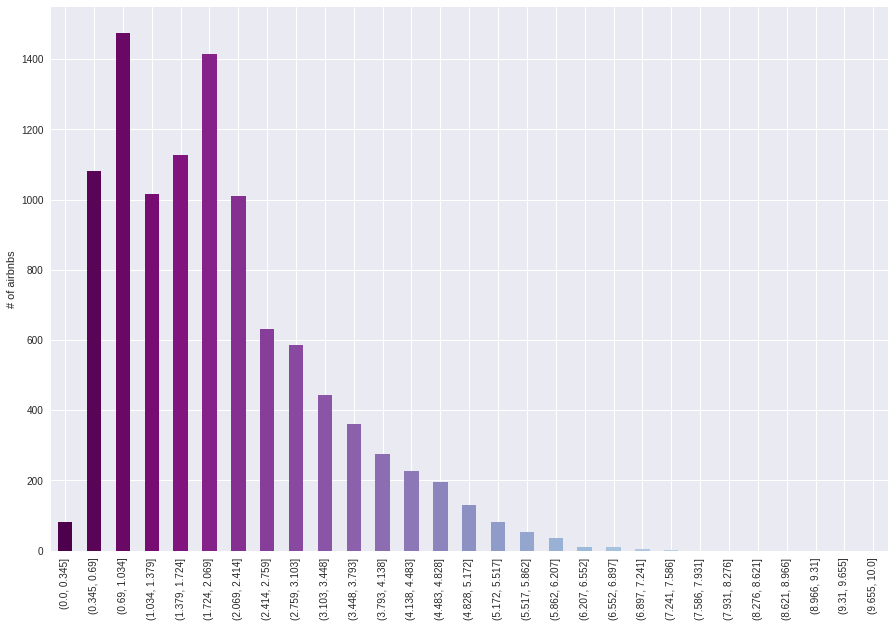

In [148]:
from math import cos, sin, asin, sqrt, radians, atan2

earth_radius = 6373.0
acripolis_coordinates = [37.971767, 23.726265]

def dist(lat1,lon1, lat2,lon2):
    dlat = radians(lat2) - radians(lat1)
    dlon = radians(lon2) - radians(lon1)

    hav = sin(dlat/2)**2 + cos(lat1)*cos(lat2) * (sin(dlon/2)**2)
    arc = asin( sqrt(hav) )
    dist = 2 * earth_radius * arc
    return dist

train["distance"] = train[["longitude", "latitude"]].apply(lambda x: dist(x["latitude"], x["longitude"], acripolis_coordinates[0], acripolis_coordinates[1]), axis=1)

# quantization of distance in 30 classes of kilometers
cut_distances = pd.cut(x=train["distance"], bins=np.linspace(0,10,30))
train["cut_distance"] = cut_distances

distances = cut_distances.value_counts()
colors = color_palet(np.linspace(1, 0, 30))
distances.sort_index().plot(kind='bar', stacked=True, figsize=(15, 10), color=colors)
plt.ylabel("# of airbnbs")

From the graph we observe, as it is logical, the volume of the apartments to exist near the Acropolis, however, the small drop between the distance from 1 to 1.3 km is remarkable. This fall of airbnb can be explained by the distance of the Acropolis with the National Garden, the Panathinaiko Stadium and the First Cemetery of Athens!

The conclusion can be seen in the following heat map with the two cycles enclosing the distance between 1 and 1.3 kilometers. 

In [149]:
# fig_c = Figure(width=840, height=480)
# map = folium.Map(location=acripolis_coordinates,zoom_start=13, width=840, height=480, control_scale=True)
# fig_c.add_child(heat_map)
folium.Circle(acripolis_coordinates, radius=1000).add_to(heat_map)
folium.Circle(acripolis_coordinates, radius=1300).add_to(heat_map)
heat_map


Find and their average value as a function of their distance from the Acropolis 

Text(0, 0.5, 'Average price')

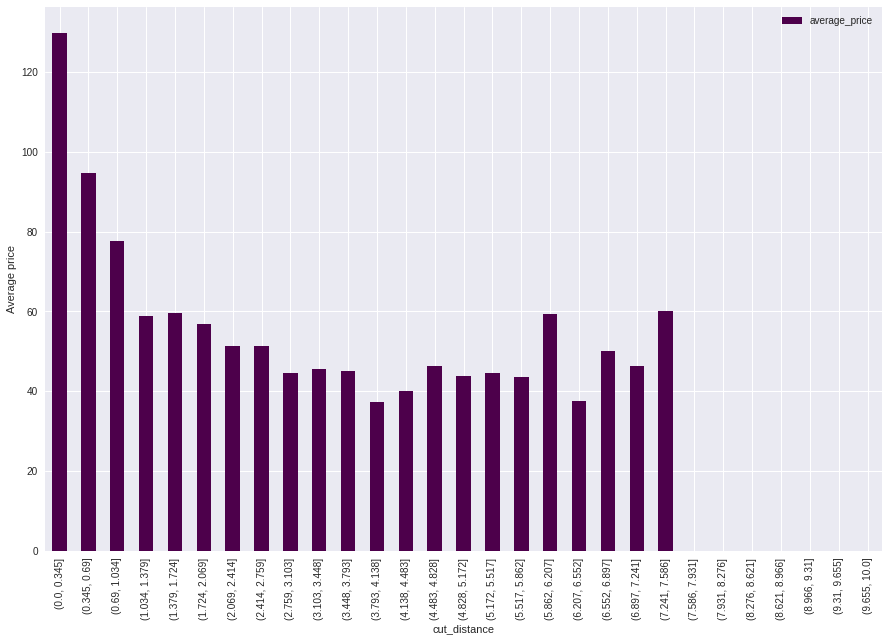

In [150]:
distance_group = train[["cut_distance", "average_price"]].groupby("cut_distance").mean()
distance_group

# ploting
colors = color_palet(np.linspace(1, 0, 30))
distance_group.sort_index().plot(kind='bar', stacked=True, figsize=(15, 10), color=colors)
plt.ylabel("Average price")

## Question 1.13 Find the most value for money airbnb 

As we now know the relative price for each house per person as well as the distance of each house from the biggest point of interest in Athens, we could calculate how relatively good the value of each airbnb is.

To calculate it we will even use the total number of reviews and the number of different benefits offered. We will be able to take into account the scores of the critics but we noticed that they are not accurate and most of them are either 100 or Nan.

A simple formula for this calculation could be:


Κρι Number of reviews * Total Amenities} / {Distance from Acropolis * Price per person}

All you have to do is find it for each airbnb and sort it. 

In [151]:
train["relative_price"] = train["average_price"].div(train.accommodates)
len(train.amenities[1000].split(","))
train["value"] = train[["amenities", "number_of_reviews", "distance", "relative_price"]].apply(lambda x: (len(x.amenities.split(",")) * x.number_of_reviews) / 
                                                                                                      (x.distance  *  x.relative_price ) if x.distance*x.relative_price != 0 else 0,axis=1)
train.sort_values(by="value", ascending=False).head(10)


,id,price_febrouary,on_febrouary,price_march,on_march,price_april,on_april,instant_bookable,accommodates,latitude,...,host_has_profile_pic,host_response_rate,minimum_nights,average_price,last_review,number_of_reviews,distance,cut_distance,relative_price,value
233,1232279.0,40.0,1.0,40.0,1.0,40.0,1.0,f,10.0,37.97712,...,t,100%,1.0,40.0,2019-02-27,253.0,0.597316,"(0.345, 0.69]",4.000000,5823.973527
2072,14865208.0,44.0,1.0,44.0,1.0,44.0,1.0,t,9.0,37.97368,...,t,100%,1.0,44.0,2019-04-06,238.0,0.569727,"(0.345, 0.69]",4.888889,4785.068969
700,6069036.0,44.0,1.0,44.0,1.0,44.0,1.0,t,6.0,37.97284,...,t,100%,1.0,44.0,2019-03-24,288.0,0.323268,"(0.0, 0.345]",7.333333,4009.062694
1502,12621601.0,45.0,1.0,45.0,1.0,45.0,1.0,f,9.0,37.97855,...,t,100%,1.0,45.0,2019-03-30,260.0,0.793112,"(0.69, 1.034]",5.000000,3606.050151
1167,10265257.0,12.0,1.0,12.0,1.0,12.0,1.0,t,6.0,37.96306,...,t,100%,1.0,12.0,2019-04-08,134.0,1.123237,"(1.034, 1.379]",2.000000,3459.642835
66,401423.0,54.0,1.0,54.0,1.0,54.0,1.0,t,4.0,37.96856,...,t,100%,2.0,54.0,2019-04-08,380.0,0.361464,"(0.345, 0.69]",13.500000,3270.649012
627,5428088.0,9.0,1.0,9.0,1.0,9.0,1.0,t,2.0,37.96406,...,t,100%,1.0,9.0,2019-04-08,243.0,1.037815,"(1.034, 1.379]",4.500000,3069.912619
725,6241150.0,29.0,1.0,29.0,1.0,29.0,1.0,t,4.0,37.97805,...,t,100%,1.0,29.0,2019-03-29,295.0,0.774304,"(0.69, 1.034]",7.250000,2890.248255
2812,18012163.0,10.0,1.0,10.0,1.0,10.0,1.0,t,3.0,37.96529,...,t,100%,1.0,10.0,2019-03-22,121.0,0.720709,"(0.69, 1.034]",3.333333,2820.557321
770,6513276.0,49.0,1.0,49.0,1.0,49.0,1.0,t,4.0,37.96971,...,t,100%,1.0,49.0,2019-04-11,254.0,0.229752,"(0.0, 0.345]",12.250000,2797.694505


# Question 2

## Question 2.1 TF-IDF

Find Greek stopwords which we have got from this site
https://www.translatum.gr/forum/index.php?topic=3550.0

Then we remove the tones from the words in the description text to make the words compatible with the stopwords 

In [152]:
# stop words download
import nltk
from nltk.corpus import stopwords
# nltk.download()


greek_stop_words = """ Α∆ΙΑΚΟΠΑ, ΑΙ, ΑΚΟΜΑ, ΑΚΟΜΗ, ΑΚΡΙΒΩΣ, ΑΛΗΘΕΙΑ, ΑΛΗΘΙΝΑ, ΑΛΛΑ, ΑΛΛΑΧΟΥ, ΑΛΛΕΣ, ΑΛΛΗ, ΑΛΛΗΝ, ΑΛΛΗΣ, ΑΛΛΙΩΣ, ΑΛΛΙΩΤΙΚΑ, ΑΛΛΟ, ΑΛΛΟΙ, ΑΛΛΟΙΩΣ, ΑΛΛΟΙΩΤΙΚΑ, ΑΛΛΟΝ, ΑΛΛΟΣ, ΑΛΛΟΤΕ, ΑΛΛΟΥ, ΑΛΛΟΥΣ, ΑΛΛΩΝ, ΑΜΑ, ΑΜΕΣΑ, ΑΜΕΣΩΣ, ΑΝ, ΑΝΑ, ΑΝΑΜΕΣΑ, ΑΝΑΜΕΤΑΞΥ, ΑΝΕΥ, ΑΝΤΙ, ΑΝΤΙΠΕΡΑ, ΑΝΤΙΣ, ΑΝΩ, ΑΝΩΤΕΡΩ, ΑΞΑΦΝΑ, ΑΠ, ΑΠΕΝΑΝΤΙ, ΑΠΟ, ΑΠΟΨΕ, ΑΡΑ, ΑΡΑΓΕ, ΑΡΓΑ, ΑΡΓΟΤΕΡΟ, ΑΡΙΣΤΕΡΑ, ΑΡΚΕΤΑ, ΑΡΧΙΚΑ, ΑΣ, ΑΥΡΙΟ, ΑΥΤΑ, ΑΥΤΕΣ, ΑΥΤΗ, ΑΥΤΗΝ, ΑΥΤΗΣ, ΑΥΤΟ, ΑΥΤΟΙ, ΑΥΤΟΝ, ΑΥΤΟΣ, ΑΥΤΟΥ, ΑΥΤΟΥΣ, ΑΥΤΩΝ, ΑΦΟΤΟΥ, ΑΦΟΥ, ΒΕΒΑΙΑ, ΒΕΒΑΙΟΤΑΤΑ, ΓΙ, ΓΙΑ, ΓΡΗΓΟΡΑ, ΓΥΡΩ, ∆Α, ∆Ε, ∆ΕΙΝΑ, ∆ΕΝ, ∆ΕΞΙΑ, ∆ΗΘΕΝ, ∆ΗΛΑ∆Η, ∆Ι, ∆ΙΑ, ∆ΙΑΡΚΩΣ, ∆ΙΚΑ, ∆ΙΚΟ, ∆ΙΚΟΙ, ∆ΙΚΟΣ, ∆ΙΚΟΥ, ∆ΙΚΟΥΣ, ∆ΙΟΛΟΥ, ∆ΙΠΛΑ, ∆ΙΧΩΣ, ΕΑΝ, ΕΑΥΤΟ, ΕΑΥΤΟΝ, ΕΑΥΤΟΥ, ΕΑΥΤΟΥΣ, ΕΑΥΤΩΝ, ΕΓΚΑΙΡΑ, ΕΓΚΑΙΡΩΣ, ΕΓΩ, Ε∆Ω, ΕΙ∆ΕΜΗ, ΕΙΘΕ, ΕΙΜΑΙ, ΕΙΜΑΣΤΕ, ΕΙΝΑΙ, ΕΙΣ, ΕΙΣΑΙ, ΕΙΣΑΣΤΕ, ΕΙΣΤΕ, ΕΙΤΕ, ΕΙΧΑ, ΕΙΧΑΜΕ, ΕΙΧΑΝ, ΕΙΧΑΤΕ, ΕΙΧΕ, ΕΙΧΕΣ, ΕΚΑΣΤΑ, ΕΚΑΣΤΕΣ, ΕΚΑΣΤΗ, ΕΚΑΣΤΗΝ, ΕΚΑΣΤΗΣ, ΕΚΑΣΤΟ, ΕΚΑΣΤΟΙ, ΕΚΑΣΤΟΝ, ΕΚΑΣΤΟΣ, ΕΚΑΣΤΟΥ, ΕΚΑΣΤΟΥΣ, ΕΚΑΣΤΩΝ, ΕΚΕΙ, ΕΚΕΙΝΑ, ΕΚΕΙΝΕΣ, ΕΚΕΙΝΗ, ΕΚΕΙΝΗΝ, ΕΚΕΙΝΗΣ, ΕΚΕΙΝΟ, ΕΚΕΙΝΟΙ, ΕΚΕΙΝΟΝ, ΕΚΕΙΝΟΣ, ΕΚΕΙΝΟΥ, ΕΚΕΙΝΟΥΣ, ΕΚΕΙΝΩΝ, ΕΚΤΟΣ, ΕΜΑΣ, ΕΜΕΙΣ, ΕΜΕΝΑ, ΕΜΠΡΟΣ, ΕΝ, ΕΝΑ, ΕΝΑΝ, ΕΝΑΣ, ΕΝΟΣ, ΕΝΤΕΛΩΣ, ΕΝΤΟΣ, ΕΝΤΩΜΕΤΑΞΥ, ΕΝΩ, ΕΞ, ΕΞΑΦΝΑ, ΕΞΗΣ, ΕΞΙΣΟΥ, ΕΞΩ, ΕΠΑΝΩ, ΕΠΕΙ∆Η, ΕΠΕΙΤΑ, ΕΠΙ, ΕΠΙΣΗΣ, ΕΠΟΜΕΝΩΣ, ΕΣΑΣ, ΕΣΕΙΣ, ΕΣΕΝΑ, ΕΣΤΩ, ΕΣΥ, ΕΤΕΡΑ, ΕΤΕΡΑΙ, ΕΤΕΡΑΣ, ΕΤΕΡΕΣ, ΕΤΕΡΗ, ΕΤΕΡΗΣ, ΕΤΕΡΟ, ΕΤΕΡΟΙ, ΕΤΕΡΟΝ, ΕΤΕΡΟΣ, ΕΤΕΡΟΥ, ΕΤΕΡΟΥΣ, ΕΤΕΡΩΝ, ΕΤΟΥΤΑ, ΕΤΟΥΤΕΣ, ΕΤΟΥΤΗ, ΕΤΟΥΤΗΝ, ΕΤΟΥΤΗΣ, ΕΤΟΥΤΟ, ΕΤΟΥΤΟΙ, ΕΤΟΥΤΟΝ, ΕΤΟΥΤΟΣ, ΕΤΟΥΤΟΥ, ΕΤΟΥΤΟΥΣ, ΕΤΟΥΤΩΝ, ΕΤΣΙ, ΕΥΓΕ, ΕΥΘΥΣ, ΕΥΤΥΧΩΣ, ΕΦΕΞΗΣ, ΕΧΕΙ, ΕΧΕΙΣ, ΕΧΕΤΕ, ΕΧΘΕΣ, ΕΧΟΜΕ, ΕΧΟΥΜΕ, ΕΧΟΥΝ, ΕΧΤΕΣ, ΕΧΩ, ΕΩΣ, Η, Η∆Η, ΗΜΑΣΤΑΝ, ΗΜΑΣΤΕ, ΗΜΟΥΝ, ΗΣΑΣΤΑΝ, ΗΣΑΣΤΕ, ΗΣΟΥΝ, ΗΤΑΝ, ΗΤΑΝΕ, ΗΤΟΙ, ΗΤΤΟΝ, ΘΑ, Ι, Ι∆ΙΑ, Ι∆ΙΑΝ, Ι∆ΙΑΣ, Ι∆ΙΕΣ, Ι∆ΙΟ, Ι∆ΙΟΙ, Ι∆ΙΟΝ, Ι∆ΙΟΣ, Ι∆ΙΟΥ, Ι∆ΙΟΥΣ, Ι∆ΙΩΝ, Ι∆ΙΩΣ, ΙΙ, ΙΙΙ, ΙΣΑΜΕ, ΙΣΙΑ, ΙΣΩΣ, ΚΑΘΕ, ΚΑΘΕΜΙΑ, ΚΑΘΕΜΙΑΣ, ΚΑΘΕΝΑ, ΚΑΘΕΝΑΣ, ΚΑΘΕΝΟΣ, ΚΑΘΕΤΙ, ΚΑΘΟΛΟΥ, ΚΑΘΩΣ, ΚΑΙ, ΚΑΚΑ, ΚΑΚΩΣ, ΚΑΛΑ, ΚΑΛΩΣ, ΚΑΜΙΑ, ΚΑΜΙΑΝ, ΚΑΜΙΑΣ, ΚΑΜΠΟΣΑ, ΚΑΜΠΟΣΕΣ, ΚΑΜΠΟΣΗ, ΚΑΜΠΟΣΗΝ, ΚΑΜΠΟΣΗΣ, ΚΑΜΠΟΣΟ, ΚΑΜΠΟΣΟΙ, ΚΑΜΠΟΣΟΝ, ΚΑΜΠΟΣΟΣ, ΚΑΜΠΟΣΟΥ, ΚΑΜΠΟΣΟΥΣ, ΚΑΜΠΟΣΩΝ, ΚΑΝΕΙΣ, ΚΑΝΕΝ, ΚΑΝΕΝΑ, ΚΑΝΕΝΑΝ, ΚΑΝΕΝΑΣ, ΚΑΝΕΝΟΣ, ΚΑΠΟΙΑ, ΚΑΠΟΙΑΝ, ΚΑΠΟΙΑΣ, ΚΑΠΟΙΕΣ, ΚΑΠΟΙΟ, ΚΑΠΟΙΟΙ, ΚΑΠΟΙΟΝ, ΚΑΠΟΙΟΣ, ΚΑΠΟΙΟΥ, ΚΑΠΟΙΟΥΣ, ΚΑΠΟΙΩΝ, ΚΑΠΟΤΕ, ΚΑΠΟΥ, ΚΑΠΩΣ, ΚΑΤ, ΚΑΤΑ, ΚΑΤΙ, ΚΑΤΙΤΙ, ΚΑΤΟΠΙΝ, ΚΑΤΩ, ΚΙΟΛΑΣ, ΚΛΠ, ΚΟΝΤΑ, ΚΤΛ, ΚΥΡΙΩΣ, ΛΙΓΑΚΙ, ΛΙΓΟ, ΛΙΓΩΤΕΡΟ, ΛΟΓΩ, ΛΟΙΠΑ, ΛΟΙΠΟΝ, ΜΑ, ΜΑΖΙ, ΜΑΚΑΡΙ, ΜΑΚΡΥΑ, ΜΑΛΙΣΤΑ, ΜΑΛΛΟΝ, ΜΑΣ, ΜΕ, ΜΕΘΑΥΡΙΟ, ΜΕΙΟΝ, ΜΕΛΕΙ, ΜΕΛΛΕΤΑΙ, ΜΕΜΙΑΣ, ΜΕΝ, ΜΕΡΙΚΑ, ΜΕΡΙΚΕΣ, ΜΕΡΙΚΟΙ, ΜΕΡΙΚΟΥΣ, ΜΕΡΙΚΩΝ, ΜΕΣΑ, ΜΕΤ, ΜΕΤΑ, ΜΕΤΑΞΥ, ΜΕΧΡΙ, ΜΗ, ΜΗ∆Ε, ΜΗΝ, ΜΗΠΩΣ, ΜΗΤΕ, ΜΙΑ, ΜΙΑΝ, ΜΙΑΣ, ΜΟΛΙΣ, ΜΟΛΟΝΟΤΙ, ΜΟΝΑΧΑ, ΜΟΝΕΣ, ΜΟΝΗ, ΜΟΝΗΝ, ΜΟΝΗΣ, ΜΟΝΟ, ΜΟΝΟΙ, ΜΟΝΟΜΙΑΣ, ΜΟΝΟΣ, ΜΟΝΟΥ, ΜΟΝΟΥΣ, ΜΟΝΩΝ, ΜΟΥ, ΜΠΟΡΕΙ, ΜΠΟΡΟΥΝ, ΜΠΡΑΒΟ, ΜΠΡΟΣ, ΝΑ, ΝΑΙ, ΝΩΡΙΣ, ΞΑΝΑ, ΞΑΦΝΙΚΑ, Ο, ΟΙ, ΟΛΑ, ΟΛΕΣ, ΟΛΗ, ΟΛΗΝ, ΟΛΗΣ, ΟΛΟ, ΟΛΟΓΥΡΑ, ΟΛΟΙ, ΟΛΟΝ, ΟΛΟΝΕΝ, ΟΛΟΣ, ΟΛΟΤΕΛΑ, ΟΛΟΥ, ΟΛΟΥΣ, ΟΛΩΝ, ΟΛΩΣ, ΟΛΩΣ∆ΙΟΛΟΥ, ΟΜΩΣ, ΟΠΟΙΑ, ΟΠΟΙΑ∆ΗΠΟΤΕ, ΟΠΟΙΑΝ, ΟΠΟΙΑΝ∆ΗΠΟΤΕ, ΟΠΟΙΑΣ, ΟΠΟΙΑΣ∆ΗΠΟΤΕ, ΟΠΟΙ∆ΗΠΟΤΕ, ΟΠΟΙΕΣ, ΟΠΟΙΕΣ∆ΗΠΟΤΕ, ΟΠΟΙΟ, ΟΠΟΙΟ∆ΗΠΟΤΕ, ΟΠΟΙΟΙ, ΟΠΟΙΟΝ, ΟΠΟΙΟΝ∆ΗΠΟΤΕ, ΟΠΟΙΟΣ, ΟΠΟΙΟΣ∆ΗΠΟΤΕ, ΟΠΟΙΟΥ, ΟΠΟΙΟΥ∆ΗΠΟΤΕ, ΟΠΟΙΟΥΣ, ΟΠΟΙΟΥΣ∆ΗΠΟΤΕ, ΟΠΟΙΩΝ, ΟΠΟΙΩΝ∆ΗΠΟΤΕ, ΟΠΟΤΕ, ΟΠΟΤΕ∆ΗΠΟΤΕ, ΟΠΟΥ, ΟΠΟΥ∆ΗΠΟΤΕ, ΟΠΩΣ, ΟΡΙΣΜΕΝΑ, ΟΡΙΣΜΕΝΕΣ, ΟΡΙΣΜΕΝΩΝ, ΟΡΙΣΜΕΝΩΣ, ΟΣΑ, ΟΣΑ∆ΗΠΟΤΕ, ΟΣΕΣ, ΟΣΕΣ∆ΗΠΟΤΕ, ΟΣΗ, ΟΣΗ∆ΗΠΟΤΕ, ΟΣΗΝ, ΟΣΗΝ∆ΗΠΟΤΕ, ΟΣΗΣ, ΟΣΗΣ∆ΗΠΟΤΕ, ΟΣΟ, ΟΣΟ∆ΗΠΟΤΕ, ΟΣΟΙ, ΟΣΟΙ∆ΗΠΟΤΕ, ΟΣΟΝ, ΟΣΟΝ∆ΗΠΟΤΕ, ΟΣΟΣ, ΟΣΟΣ∆ΗΠΟΤΕ, ΟΣΟΥ, ΟΣΟΥ∆ΗΠΟΤΕ, ΟΣΟΥΣ, ΟΣΟΥΣ∆ΗΠΟΤΕ, ΟΣΩΝ, ΟΣΩΝ∆ΗΠΟΤΕ, ΟΤΑΝ, ΟΤΙ, ΟΤΙ∆ΗΠΟΤΕ, ΟΤΟΥ, ΟΥ, ΟΥ∆Ε, ΟΥΤΕ, ΟΧΙ, ΠΑΛΙ, ΠΑΝΤΟΤΕ, ΠΑΝΤΟΥ, ΠΑΝΤΩΣ, ΠΑΡΑ, ΠΕΡΑ, ΠΕΡΙ, ΠΕΡΙΠΟΥ, ΠΕΡΙΣΣΟΤΕΡΟ, ΠΕΡΣΙ, ΠΕΡΥΣΙ, ΠΙΑ, ΠΙΘΑΝΟΝ, ΠΙΟ, ΠΙΣΩ, ΠΛΑΙ, ΠΛΕΟΝ, ΠΛΗΝ, ΠΟΙΑ, ΠΟΙΑΝ, ΠΟΙΑΣ, ΠΟΙΕΣ, ΠΟΙΟ, ΠΟΙΟΙ, ΠΟΙΟΝ, ΠΟΙΟΣ, ΠΟΙΟΥ, ΠΟΙΟΥΣ, ΠΟΙΩΝ, ΠΟΛΥ, ΠΟΣΕΣ, ΠΟΣΗ, ΠΟΣΗΝ, ΠΟΣΗΣ, ΠΟΣΟΙ, ΠΟΣΟΣ, ΠΟΣΟΥΣ, ΠΟΤΕ, ΠΟΥ, ΠΟΥΘΕ, ΠΟΥΘΕΝΑ, ΠΡΕΠΕΙ, ΠΡΙΝ, ΠΡΟ, ΠΡΟΚΕΙΜΕΝΟΥ, ΠΡΟΚΕΙΤΑΙ, ΠΡΟΠΕΡΣΙ, ΠΡΟΣ, ΠΡΟΤΟΥ, ΠΡΟΧΘΕΣ, ΠΡΟΧΤΕΣ, ΠΡΩΤΥΤΕΡΑ, ΠΩΣ, ΣΑΝ, ΣΑΣ, ΣΕ, ΣΕΙΣ, ΣΗΜΕΡΑ, ΣΙΓΑ, ΣΟΥ, ΣΤΑ, ΣΤΗ, ΣΤΗΝ, ΣΤΗΣ, ΣΤΙΣ, ΣΤΟ, ΣΤΟΝ, ΣΤΟΥ, ΣΤΟΥΣ, ΣΤΩΝ, ΣΥΓΧΡΟΝΩΣ, ΣΥΝ, ΣΥΝΑΜΑ, ΣΥΝΕΠΩΣ, ΣΥΝΗΘΩΣ, ΣΥΧΝΑ, ΣΥΧΝΑΣ, ΣΥΧΝΕΣ, ΣΥΧΝΗ, ΣΥΧΝΗΝ, ΣΥΧΝΗΣ, ΣΥΧΝΟ, ΣΥΧΝΟΙ, ΣΥΧΝΟΝ, ΣΥΧΝΟΣ, ΣΥΧΝΟΥ, ΣΥΧΝΟΥ, ΣΥΧΝΟΥΣ, ΣΥΧΝΩΝ, ΣΥΧΝΩΣ, ΣΧΕ∆ΟΝ, ΣΩΣΤΑ, ΤΑ, ΤΑ∆Ε, ΤΑΥΤΑ, ΤΑΥΤΕΣ, ΤΑΥΤΗ, ΤΑΥΤΗΝ, ΤΑΥΤΗΣ, ΤΑΥΤΟ,ΤΑΥΤΟΝ, ΤΑΥΤΟΣ, ΤΑΥΤΟΥ, ΤΑΥΤΩΝ, ΤΑΧΑ, ΤΑΧΑΤΕ, ΤΕΛΙΚΑ, ΤΕΛΙΚΩΣ, ΤΕΣ, ΤΕΤΟΙΑ, ΤΕΤΟΙΑΝ, ΤΕΤΟΙΑΣ, ΤΕΤΟΙΕΣ, ΤΕΤΟΙΟ, ΤΕΤΟΙΟΙ, ΤΕΤΟΙΟΝ, ΤΕΤΟΙΟΣ, ΤΕΤΟΙΟΥ, ΤΕΤΟΙΟΥΣ, ΤΕΤΟΙΩΝ, ΤΗ, ΤΗΝ, ΤΗΣ, ΤΙ, ΤΙΠΟΤΑ, ΤΙΠΟΤΕ, ΤΙΣ, ΤΟ, ΤΟΙ, ΤΟΝ, ΤΟΣ, ΤΟΣΑ, ΤΟΣΕΣ, ΤΟΣΗ, ΤΟΣΗΝ, ΤΟΣΗΣ, ΤΟΣΟ, ΤΟΣΟΙ, ΤΟΣΟΝ, ΤΟΣΟΣ, ΤΟΣΟΥ, ΤΟΣΟΥΣ, ΤΟΣΩΝ, ΤΟΤΕ, ΤΟΥ, ΤΟΥΛΑΧΙΣΤΟ, ΤΟΥΛΑΧΙΣΤΟΝ, ΤΟΥΣ, ΤΟΥΤΑ, ΤΟΥΤΕΣ, ΤΟΥΤΗ, ΤΟΥΤΗΝ, ΤΟΥΤΗΣ, ΤΟΥΤΟ, ΤΟΥΤΟΙ, ΤΟΥΤΟΙΣ, ΤΟΥΤΟΝ, ΤΟΥΤΟΣ, ΤΟΥΤΟΥ, ΤΟΥΤΟΥΣ, ΤΟΥΤΩΝ, ΤΥΧΟΝ, ΤΩΝ, ΤΩΡΑ, ΥΠ, ΥΠΕΡ, ΥΠΟ, ΥΠΟΨΗ, ΥΠΟΨΙΝ, ΥΣΤΕΡΑ, ΦΕΤΟΣ, ΧΑΜΗΛΑ, ΧΘΕΣ, ΧΤΕΣ, ΧΩΡΙΣ, ΧΩΡΙΣΤΑ, ΨΗΛΑ, Ω, ΩΡΑΙΑ, ΩΣ, ΩΣΑΝ, ΩΣΟΤΟΥ, ΩΣΠΟΥ, ΩΣΤΕ, ΩΣΤΟΣΟ, ΩΧ"""
greek_stop_words = list(greek_stop_words.lower().split(', '))

def refine_greek(x):
    return x.upper().replace("Ά","Α").replace("Έ","Ε").replace("Ή","Η").replace("Ί","Ι").replace("Ό","Ο").replace("Ύ","Υ").replace("Ώ","Ω")

# exctracting all the commends and make the new dataFrame
train_rec = train[["id", "name", "description"]].copy()

# concate  description + name for the train set
train_text = list(train_rec["description"]+" "+train_rec["name"])
train_text = [refine_greek(word).lower() for word in train_text]

# remove stop words from the list
stop_words = stopwords.words("english") + greek_stop_words
stop_words = set(stop_words)

for sentence in range(len(train_text)):
    train_text[sentence] = ' '.join([word for word in train_text[sentence].split() if word not in stop_words])


In [153]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_df=1.0, min_df=1, max_features=15000, stop_words=stop_words, ngram_range=(1,2))

# fit and transform the model
tfidf = vectorizer.fit_transform(train_text)

/home/andreas/.local/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ει', 'εινα', 'εμη', 'εξια', 'επει', 'ηθεν', 'ηλα', 'ηποτε', 'ια', 'ιακοπα', 'ιαν', 'ιαρκως', 'ιας', 'ιες', 'ικα', 'ικο', 'ικοι', 'ικος', 'ικου', 'ικους', 'ιο', 'ιοι', 'ιολου', 'ιον', 'ιος', 'ιου', 'ιους', 'ιπλα', 'ιχως', 'ιων', 'ιως', 'ον', 'οποι', 'σχε', 'ταυτο', 'ταυτον'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


## Question 2.2 Cosine similarity and storage of 100 more similar ones 

Find the cosine similarity and subtract the diagonal and lower diagonal values since the table is symmetric and does not need all the data 

In [154]:
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse
import time

t1 = time.time()
# tfidf = sparse.csr_matrix(tfidf)
similarity = cosine_similarity(tfidf)

# similarity = np.triu(similarity)
np.fill_diagonal(similarity, 0)

t2 = time.time()
print("time: ",t2-t1)
print(similarity)

time:  6.1764209270477295
[[0.         0.76085931 0.77980067 ... 0.04253693 0.03440335 0.01125639]
 [0.76085931 0.         0.79324779 ... 0.03660325 0.0288809  0.01001779]
 [0.77980067 0.79324779 0.         ... 0.03863699 0.03617998 0.0105744 ]
 ...
 [0.04253693 0.03660325 0.03863699 ... 0.         0.02384962 0.        ]
 [0.03440335 0.0288809  0.03617998 ... 0.02384962 0.         0.03449018]
 [0.01125639 0.01001779 0.0105744  ... 0.         0.03449018 0.        ]]


Find the 100 closest pairs
First the table is converted into an array and then using argpartition are the 100 closest
Then the name and description of the nearest property are printed and at the end
a dictionary with the key the id of one property from the pair and data the id of the other pair 

In [155]:
shape = similarity.shape
# flat_indices = similarity.ravel().argsort()
flat_similarity = similarity.ravel()
flat_indices = np.argpartition(flat_similarity, -100)[-100:]
matrix_indeces = np.unravel_index(flat_indices[-100:], shape)
matrix_indeces = list(zip(matrix_indeces[0],matrix_indeces[1]))

print("100 of the most similar pairs\n")
pair = 0
similarity_dict = {}
for index in matrix_indeces:
    pair += 1
    print("Pair ",pair)
    print("**************************************************")
    print("id 1: ",train_rec.iloc[index[0]]["id"])
    print("name 1: "+train_rec.iloc[index[0]]["name"])
    print("description 1: "+train_rec.iloc[index[0]].description)
    print("--------------")
    print("id 1: ",train_rec.iloc[index[1]]["id"])
    print("name 1: "+train_rec.iloc[index[1]]["name"])
    print("description 1: "+train_rec.iloc[index[1]].description)
    print("**************************************************")
    print("")
    similarity_dict[train_rec.iloc[index[0]].id] = train_rec.iloc[index[1]].id

print("similarity id dictionary")
similarity_dict

100 of the most similar pairs

Pair  1
**************************************************
id 1:  33291140.0
name 1: Exclusive Luxury Residence In Kato Petralona
description 1: Freshly and recently renovated apartments at Kato Petralona , Fully furnished and equipped for our guests If a guests needs something I can help him with all my pleasure A Quite neighbourhood and very close to city centre and attractions , plus a few steps from the Athens Heart Mall
--------------
id 1:  33290253.0
name 1: Exclusive Luxury Residence In Kato Petralona
description 1: Freshly and recently renovated apartments at Kato Petralona , Fully furnished and equipped for our guests If a guests needs something I can help him with all my pleasure A Quite neighbourhood and very close to city centre and attractions , plus a few steps from the Athens Heart Mall
**************************************************

Pair  2
**************************************************
id 1:  33291140.0
name 1: Exclusive Luxury R

name 1: Athens Iris Hotel
description 1: Το Athens Iris Hotel βρίσκεται στην Αθήνα. Απέχει 1,4χλμ. από το Εθνικό Αρχαιολογικό Μουσείο, περίπου 1,6χλμ. από το Εθνικό Θέατρο και 1,8χλμ. από την Πλατεία Ομονοίας. Προσφέρει δωρεάν WiFi και βεράντα. Το Γκάζι - Τεχνόπολις είναι 2,2χλμ. μακριά. Στο ξενοδοχείο σερβίρεται ευρωπαϊκό πρωινό. Η 24ωρη ρεσεψιόν μπορεί να σας δώσει χρήσιμες πληροφορίες για την περιοχή. Το Athens Iris Hotel υποδέχεται επισκέπτες της (Website hidden by Airbnb) από 12 Φεβ 2019. Η πλατεία Μοναστηρακίου και η υπαίθρια αγορά στο Μοναστηράκι είναι σε απόσταση 2,4χλμ. και 4,2χλμ αντίστοιχα από το Athens Iris Hotel. Το πλησιέστερο αεροδρόμιο είναι το Αεροδρόμιο Ελευθέριος Βενιζέλος το οποίο είναι 39χλμ. μακριά.
--------------
id 1:  33093322.0
name 1: Athens Iris Hotel
description 1: Το Athens Iris Hotel βρίσκεται στην Αθήνα. Απέχει 1,4χλμ. από το Εθνικό Αρχαιολογικό Μουσείο, περίπου 1,6χλμ. από το Εθνικό Θέατρο και 1,8χλμ. από την Πλατεία Ομονοίας. Προσφέρει δωρεάν WiFi και 

{33291140.0: 33291079.0,
 20704187.0: 20692552.0,
 20706206.0: 20704187.0,
 32852898.0: 32854113.0,
 30314683.0: 30314684.0,
 20705564.0: 20707116.0,
 32535952.0: 32730045.0,
 32707460.0: 32707856.0,
 32113426.0: 32113554.0,
 33291208.0: 33290253.0,
 32803315.0: 32801843.0,
 32620627.0: 32621170.0,
 27254673.0: 30009754.0,
 32851721.0: 32852415.0,
 32680769.0: 32680393.0,
 26118850.0: 25515948.0,
 31509913.0: 18030214.0,
 32728368.0: 32621987.0,
 33067136.0: 33092281.0,
 33453783.0: 29798791.0,
 22171010.0: 24202003.0,
 32730045.0: 32535952.0,
 32677773.0: 32679653.0,
 32882143.0: 32882960.0,
 20707116.0: 20705564.0,
 30360206.0: 30359234.0,
 32851335.0: 32852415.0,
 23135396.0: 23136177.0,
 29122586.0: 31879553.0,
 32681311.0: 32704544.0,
 33291079.0: 33290253.0,
 28357206.0: 28357761.0,
 23225556.0: 23225775.0,
 33596988.0: 33595870.0,
 33595870.0: 33596988.0,
 33431074.0: 33345814.0,
 33091714.0: 33093322.0,
 22074163.0: 22074541.0,
 32535436.0: 32882143.0,
 32854113.0: 32852898.0,


## Question 2.3

Create recommend ()
Create the similarity array from the upper diagonal table by adding the row and column values that have the same index number. 

In [156]:
def recommend(item_id, num=5):
    # get index from id
    index = train_rec[train_rec.id == item_id].index[0]

    # make the similarity array from the uper triagonal matrix
    similarity_id_row = similarity[index,:]
    similarity_id_col = similarity[:,index]
    similarity_id = np.add(similarity_id_row, similarity_id_col.transpose())

    # find the max similarities
    similarity_id_max_indeces = np.argpartition(similarity_id, -num)[-num:]
    similarity_id_index_score = [(index,similarity_id[index]) for index in similarity_id_max_indeces]

    # sort index score tuples
    similarity_id_index_score.sort(key = lambda x: x[1], reverse=True)

    # print similar airbnb
    print("Recommending 5 listings similar to ", train_rec.iloc[index]["name"])
    print("---------------------------------------------------------")
    for recommendation in similarity_id_index_score:
        print("Recommended: ",train_rec.iloc[recommendation[0]]["name"])
        print("Description: ",train_rec.iloc[recommendation[0]]["description"])
        print("(score: ", recommendation[1],")\n")

Results of recommend


In [157]:
recommend(10990,10)

Recommending 5 listings similar to  50m2, Metro, WI-FI, cableTV, more
---------------------------------------------------------
Recommended:  47m2, close to metro,cable TV,wi-fi
Description:  AQA No2 is 1-bedroom apartment (47m2)  -excellent located  -close to metro station,  -lovely,  -very clean  with all the facilities that you will need, nice balcony, excellent Wi-Fi, cable tv, fully air conditioned, etc... AQA No2 is an excellent located, close to metro, lovely, very clean 1-bedroom apartment (45 square meters) on the 2nd floor (there is elevator) with all the facilities that you will need and a very nice balcony facing the inner garden to enjoy your breakfast in the morning or relax in the evening. Separated Fully equipped kitchen with everything you need to prepare your lunch/dinner. Nice Living room to relax and enjoy a movie or a sport event. Clean nice bathroom. In case you are more than 2 people there is a sofa/bed in the living room. The studio has everything you will need.

Description:  Big 1-bedroom apartment that can accommodate 4 people. Queen size bed in the bedroom. Queen size sofa/bed in the living room. OTE TV CABLE TV, fast internet connection, 24 hours check-in. I live 50 meters away so i am here if you need anything. -We have 9 apartments. 8 of them are on the same building/area. We live on the same building area so we provide -24 hours check-in & check-out -24 hours help, problem solution & information -The apartments are excellent located so you can 24 hours access from/to the airport. -We can arrange 24 hours pick-up service by professional taxi driver. (extra charge) Lovable Experience 7 is 1-bedroom fully furnished apartment ( (Phone number hidden by Airbnb) ) which can accommodate up to 4 people. The apartment has 1 bedroom with Queen size bed, air-condition, spacious closets, Living room with 1 triple Queen size sofa/bed, air-condition, fully equipped kitchen, dinner table for 4, bathroom with hot tub and washing machine and balcony. The

## Question 2.4

Customize train_text for BigramCollocationFinder

In [158]:
# create word list for the bigram collocation finder from train_text
word_list = []
sentence_list = [word.split(" ") for word in train_text]
for sentence in sentence_list:
    word_list.extend(sentence)

Find the 10 words that "tend" to appear often together. 

In [159]:
import nltk
from nltk.collocations import *
bigram_measures = nltk.collocations.BigramAssocMeasures()

bigram_finder = BigramCollocationFinder.from_words(word_list)
top_n_bigrams = bigram_finder.nbest(bigram_measures.likelihood_ratio, 10)

for collocation in top_n_bigrams:
    print(collocation[0], collocation[1])

fully equipped
living room
walking distance
metro station
hidden airbnb)
double bed
brand new
living room,
equipped kitchen
(phone number
